In [1]:
import numpy as np
import xgboost as xgb
from sklearn import svm
from sklearn import datasets
from sklearn.cluster import KMeans
from matplotlib import pylab as plt
from sklearn.model_selection import KFold 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, mean_squared_error
from sequd import SeqUD, GPEIOPT, SMACOPT, TPEOPT

/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
random_state = 1

# Example 1: SVM for Classification

In [3]:
sx = MinMaxScaler()
dt = datasets.fetch_openml(data_id=37)
x = sx.fit_transform(dt.data)
y = dt.target

ParaSpace = {'C':{'Type': 'continuous', 'Range': [-6, 16], 'Wrapper': np.exp2}, 
             'gamma': {'Type': 'continuous', 'Range': [-16, 6], 'Wrapper': np.exp2}}

estimator = svm.SVC()
score_metric = make_scorer(accuracy_score, True)
cv = KFold(n_splits=5, random_state=random_state, shuffle=True)

/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass greater_is_better=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [4]:
sequd_clf = SeqUD(ParaSpace, n_runs_per_stage=15, max_runs=100, max_search_iter=50, n_jobs=10, 
                 estimator=estimator, cv=cv, scoring=score_metric, refit=None, random_state=random_state, verbose=True)
sequd_clf.fit(x, y)

tpe_clf = TPEOPT(ParaSpace, max_runs=100, estimator=estimator, cv=cv, scoring=score_metric,
                 refit=True, random_state=random_state, verbose=True)
tpe_clf.fit(x, y)

smac_clf = SMACOPT(ParaSpace, max_runs=100, estimator=estimator, cv=cv, scoring=score_metric,
                   refit=True, random_state=random_state, verbose=True)
smac_clf.fit(x, y)

gpei_clf = GPEIOPT(ParaSpace, max_runs=100, estimator=estimator, cv=cv, scoring=score_metric,
                   refit=True, random_state=random_state, verbose=True)
gpei_clf.fit(x, y)

Stage 1 completed (15/100) with best score: 0.77476.
Stage 2 completed (27/100) with best score: 0.77735.
Stage 3 completed (40/100) with best score: 0.77735.
Stage 4 completed (51/100) with best score: 0.77736.
Stage 5 completed (62/100) with best score: 0.78256.
Stage 6 completed (74/100) with best score: 0.78256.
Stage 7 completed (85/100) with best score: 0.78256.
Stage 8 completed (97/100) with best score: 0.78386.
Maximum number of runs reached, stop!
SeqUD completed in 6.84 seconds.
The best score is: 0.78386.
The best configurations are:
C                   : 1.66728
gamma               : 0.20856


TPE completed in 12.29 seconds.
The best score is: 0.77736.
The best configurations are:
C                   : 42.46312
gamma               : 0.01402



SMAC completed in 55.23 seconds.
The best score is: 0.77735.
The best configurations are:
C                   : 81.0382
gamma               : 0.00336



GPEI completed in 272.61 seconds.
The best score is: 0.77993.
The best configurations are:
C                   : 1.30727
gamma               : 1.19173



A contour plot based on a thorough grid search

In [ ]:
grid_num = 25
xlist = np.linspace(-6, 16, grid_num)
ylist = np.linspace(-16, 6, grid_num)
X, Y = np.meshgrid(xlist, ylist)
Z = np.zeros((grid_num, grid_num))
for i, C in enumerate(xlist):
    for j, gamma in enumerate(ylist):
        estimator = svm.SVC(C=2 ** C, gamma=2 ** gamma)
        out = cross_val_score(estimator, x, y, cv=cv, scoring=score_metric)
        Z[j,i] = np.mean(out)

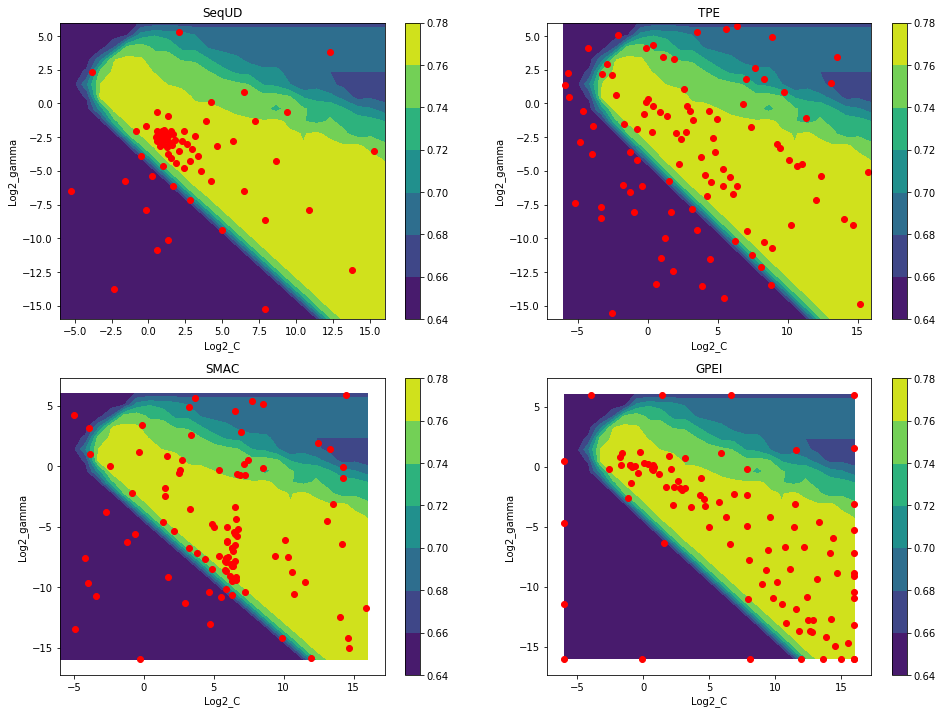

In [ ]:
def plot_trajectory(Z, clf, title):
    cp = plt.contourf(X, Y, Z)
    plt.colorbar(cp)
    plt.xlabel('Log2_C')
    plt.ylabel('Log2_gamma')
    plt.scatter(np.log2(clf.logs.loc[:, ['C']]), 
                np.log2(clf.logs.loc[:, ['gamma']]), color="red")
    plt.title(title)
    
plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plot_trajectory(Z, sequd_clf, "SeqUD")

plt.subplot(2, 2, 2)
plot_trajectory(Z, tpe_clf, "TPE")

plt.subplot(2, 2, 3)
plot_trajectory(Z, smac_clf, "SMAC")

plt.subplot(2, 2, 4)
plot_trajectory(Z, gpei_clf, "GPEI")

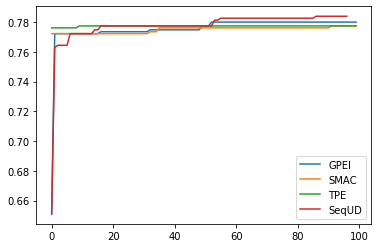

In [ ]:
plt.plot(gpei_clf.logs["score"].cummax()) 
plt.plot(smac_clf.logs["score"].cummax()) 
plt.plot(tpe_clf.logs["score"].cummax())
plt.plot(sequd_clf.logs["score"].cummax()) 
plt.legend(['GPEI', 'SMAC', 'TPE', 'SeqUD'])
plt.show()

# Example :Xgboost for Regression

In [17]:
dt = datasets.load_diabetes()
sx = MinMaxScaler()
sy = MinMaxScaler()
x = sx.fit_transform(dt.data)
y = sy.fit_transform(dt.target.reshape([-1, 1]))

ParaSpace = {'booster':          {'Type': 'categorical', 'Mapping': ['gbtree', 'gblinear']},
             'max_depth':        {'Type': 'integer',     'Mapping': np.linspace(1, 8, 8)}, 
             'n_estimators':     {'Type': 'integer',     'Mapping': np.linspace(100, 500, 401)},
             'colsample_bytree': {'Type': 'continuous',  'Range': [0.5, 1],  'Wrapper': lambda x:x},
             'learning_rate':    {'Type': 'continuous',  'Range': [-5, 0], 'Wrapper': lambda x: 10**x},
             'gamma':            {'Type': 'continuous',  'Range': [-5, 0], 'Wrapper': lambda x: 10**x},
             'reg_lambda':       {'Type': 'continuous',  'Range': [-5, 0], 'Wrapper': lambda x: 10**x},
             'reg_alpha':        {'Type': 'continuous',  'Range': [-5, 0], 'Wrapper': lambda x: 10**x}}
estimator = xgb.XGBRegressor(verbosity=0, silent=True)
def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))
score_metric = make_scorer(rmse, greater_is_better=False, scaler=sy)
cv = KFold(n_splits=5, random_state=random_state, shuffle=True)

In [18]:
sequd_clf = SeqUD(ParaSpace, n_runs_per_stage=25, max_runs=100, max_search_iter=50, n_jobs=10, 
                 estimator=estimator, cv=cv, refit=True, scoring=score_metric, random_state=random_state, verbose=True)
sequd_clf.fit(x, y)

tpe_clf = TPEOPT(ParaSpace, max_runs=100, estimator=estimator, cv=cv, scoring=score_metric,
                 refit=True, random_state=random_state, verbose=True)
tpe_clf.fit(x, y)

smac_clf = SMACOPT(ParaSpace, max_runs=100, estimator=estimator, cv=cv, scoring=score_metric,
                   refit=True, random_state=random_state, verbose=True)
smac_clf.fit(x, y)

gpei_clf = GPEIOPT(ParaSpace, max_runs=100, estimator=estimator, cv=cv, scoring=score_metric,
                   refit=True, random_state=random_state, verbose=True)
gpei_clf.fit(x, y)

Stage 1 completed (25/100) with best score: -54.69952.
Stage 2 completed (49/100) with best score: -54.69952.
Stage 3 completed (73/100) with best score: -54.51887.
Stage 4 completed (97/100) with best score: -54.51887.
Maximum number of runs reached, stop!
SeqUD completed in 10.59 seconds.
The best score is: -54.51887.
The best configurations are:
booster             : gblinear
max_depth           : 2
n_estimators        : 236
colsample_bytree    : 0.53
learning_rate       : 0.89125
gamma               : 0.00562
reg_lambda          : 0.00178
reg_alpha           : 0.00016


/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:433: RuntimeWarning: overflow encountered in true_divide
  X /= self.scale_



TPE completed in 61.29 seconds.
The best score is: -54.49038.
The best configurations are:
booster             : gblinear
max_depth           : 5
n_estimators        : 310
colsample_bytree    : 0.80645
learning_rate       : 0.94119
gamma               : 0.00118
reg_lambda          : 0.0004
reg_alpha           : 0.00015



SMAC completed in 253.95 seconds.
The best score is: -55.42593.
The best configurations are:
booster             : gblinear
max_depth           : 8
n_estimators        : 146
colsample_bytree    : 0.92326
learning_rate       : 0.876
gamma               : 0.00174
reg_lambda          : 0.00021
reg_alpha           : 1e-05



GPEI completed in 465.42 seconds.
The best score is: -55.75378.
The best configurations are:
booster             : gbtree
max_depth           : 2
n_estimators        : 500
colsample_bytree    : 0.5
learning_rate       : 0.07354
gamma               : 0.00049
reg_lambda          : 0.00073
reg_alpha           : 1.0



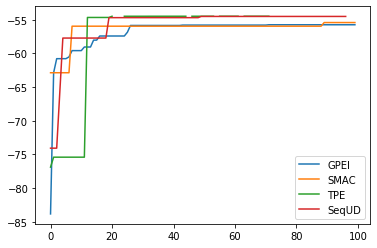

In [20]:
plt.plot(gpei_clf.logs["score"].cummax()) 
plt.plot(smac_clf.logs["score"].cummax()) 
plt.plot(tpe_clf.logs["score"].cummax())
plt.plot(sequd_clf.logs["score"].cummax()) 
plt.legend(['GPEI', 'SMAC', 'TPE', 'SeqUD'])
plt.show()

 # Example 3: Kmeans for Unsupervised Clustering  

In [25]:
sx = MinMaxScaler()
dt = datasets.load_iris()
x = sx.fit_transform(dt.data)
y = dt.target.reshape([-1, 1])

random_state = 0
ParaSpace = {'n_clusters':  {'Type': 'integer',    'Mapping': np.linspace(2, 9, 8)}, 
             'tol':         {'Type': 'continuous', 'Range': [-6, -1], 'Wrapper': lambda x: 10**x}}
estimator = KMeans()
cv = KFold(n_splits=5, random_state=random_state, shuffle=True)

In [26]:
sequd_clf = SeqUD(ParaSpace, n_runs_per_stage=15, max_runs=100, max_search_iter=50, n_jobs=10, 
                 estimator=estimator, cv=cv, refit=True, random_state=random_state, verbose=True)
sequd_clf.fit(x)

tpe_clf = TPEOPT(ParaSpace, max_runs=100, estimator=estimator, cv=cv,
                 refit=True, random_state=random_state, verbose=True)
tpe_clf.fit(x)

smac_clf = SMACOPT(ParaSpace,max_runs=100, estimator=estimator, cv=cv,
                   refit=True, random_state=random_state, verbose=True)
smac_clf.fit(x)

gpei_clf = GPEIOPT(ParaSpace, max_runs=100, estimator=estimator, cv=cv,
                   refit=True, random_state=random_state, verbose=True)
gpei_clf.fit(x)

Stage 1 completed (15/100) with best score: -0.68628.
Stage 2 completed (26/100) with best score: -0.68511.
Stage 3 completed (38/100) with best score: -0.68511.
Stage 4 completed (49/100) with best score: -0.68511.
Stage 5 completed (61/100) with best score: -0.68511.
Stage 6 completed (74/100) with best score: -0.68511.
Stage 7 completed (87/100) with best score: -0.68511.
Stage 8 completed (98/100) with best score: -0.68511.
Maximum number of runs reached, stop!
SeqUD completed in 8.26 seconds.
The best score is: -0.68511.
The best configurations are:
n_clusters          : 9
tol                 : 0.00464


TPE completed in 22.12 seconds.
The best score is: -0.68363.
The best configurations are:
n_clusters          : 9
tol                 : 0.05947


SMAC completed in 42.25 seconds.
The best score is: -0.68628.
The best configurations are:
n_clusters          : 9
tol                 : 0.00011


GPEI completed in 307.69 seconds.
The best score is: -0.68511.
The best configurations are:
n_clusters          : 9
tol                 : 0.00535


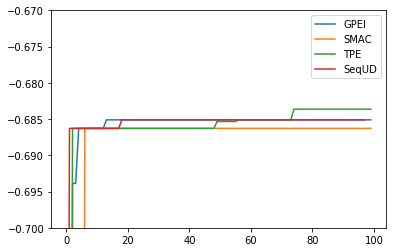

In [28]:
plt.plot(gpei_clf.logs["score"].cummax()) 
plt.plot(smac_clf.logs["score"].cummax()) 
plt.plot(tpe_clf.logs["score"].cummax())
plt.plot(sequd_clf.logs["score"].cummax()) 
plt.legend(['GPEI', 'SMAC', 'TPE', 'SeqUD'])
plt.ylim(-0.7, -0.67)
plt.show()